TODO
 * better cut off for LFIs / specifics for cov2covsmooth() and build_covmatrix()
 * lensing reconstruction on
     * PICO, mv, smica, and GNILC
     * Planck, NPIPE, and DX12
 * fix SMICA for NPIPE lens
 * run NPIPE sim
 * finish refactoring check_improvement.ipynb
 * How well does the fit do? Check error bars on spectral mismatch
 * Start draft for NPIPE paper
 * preprocessing: validate and check dependence on mask / dataset
 * derive theoretical N0
 * simid = -1 for data, remove csu.simid
 
 
Status

Lensing reconstruction on Pico with own compsep, and Matthieus GNILC
 * Pico mv calculation
     * perhaps bug in choosing frequency bands deconvoluting with beams. Works if no gap in channels for pick
 * Pico paramfile
     * to be updated

Improvement on lensing reconstruction when using NPIPE data
 * smica fit
     * not all runs satisfactory
     * Recent results too optimistic as much were kept fixed
 * smica fit mismatch
     * calculate chi^2. Still to be done
 * cutoff of noisy channels
     * find robust cutoff. This even seems to screw with pure MV Clmin. DX12 lens gives unreasonable result
 * lensing reconstruction on NPIPE/lens, DX12/smica
     * what is the transferfunction? no Pixwin and 5arcmin smoothing. In addition, there seems to be a factor 2*fsky for dx12smica data, but for lens?
 * raw improvement on variance
     * check improvement.ipynb needs to be updated and run - compares NPIPE-lens-spectra-convolved-with-DX12smica-weights with NPIPE-lens-spectra-with-NPIPE-lens-weights

In [1]:
%%capture
import warnings
warnings.filterwarnings('ignore')

import os, sys
import json
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from healpy.sphtfunc import smoothing
import smica
import copy
from astropy.io import fits
from scipy import interpolate

import component_separation.transformer as trsf
import component_separation.map as mp
from component_separation.cs_util import Config
from component_separation.cs_util import Smica_bins as const
from component_separation.io import IO
import component_separation.powerspectrum as pospec
from component_separation.cs_util import Helperfunctions as hpf
from component_separation.cs_util import Filename_gen as fn_gen
from component_separation.cs_util import Filename_gen_SMICA as fns_gen

import component_separation.smica_interface as smint
import component_separation.map as mp
import component_separation.covariance as cv

apo = csu.spectrum_type == 'pseudo'
csu = Config(freqdset='NPIPE', mskset='lens', spectrum_type='JC')
io = IO(csu)
fn = fn_gen(csu)
fns = fns_gen(csu)
bins = csu.bins
TEB = 1
simid = -1
beamf = io.load_beamf(csu.freqcomb, csu.lmax, csu.freqdatsplit)
tmask_fn = fn.get_mask('T', apodized=apo)
pmask_fn = fn.get_mask('P', apodized=apo)
tmask_sg = io.load_mask(tmask_fn)
pmask_sg = io.load_mask(pmask_fn)
tmask, pmask = dict(), dict()
for FREQ in csu.FREQ:
    if FREQ not in csu.FREQFILTER:
        tmask[FREQ] = tmask_sg
        pmask[FREQ] = pmask_sg

NameError: name 'csu' is not defined

# SMICA input and ouptput
Config.json specific
## Header

In [2]:
lmaxbins = int(csu.bins[-1][1])
colors = csu.CB_color_cycle
Tscale = "K_CMB"
bins = csu.bins

NameError: name 'csu' is not defined

In [ ]:
Cltot = io.load_data(fn.get_spectrum("T", "non-separated", simid=-1))
covltot = cv.build_covmatrices(Cltot, Tscale, csu.freqcomb, csu.FREQ_f, csu.cutoff_freq, 1100)

ClN = io.load_data(fn.get_spectrum("N", "non-separated", simid=-1))
covlN = cv.build_covmatrices(ClN, Tscale, csu.freqcomb, csu.FREQ_f, csu.cutoff_freq, 1100)

ClS = io.load_data(fns.get_spectrum("S", "non-separated", simid=-1))
covlS = cv.build_covmatrices(ClS, Tscale, csu.freqcomb, csu.FREQ_f, csu.cutoff_freq, 1100)

smica_params = dict({'cov': None, "cov4D": None, "CMB": None, "gal_mm": None, "w": None})
for k, v in smica_params.items():
    smica_params[k] = io.load_data(fns.get_misc(k))

Clmin = io.load_data(fns.get_spectrum("T", "combined", simid=-1))


Mapmin = io.load_data(fns.get_map("T", "combined", simid=-1))
Mapmin_smoothed = io.load_data(fns.get_map("T", "combined", simid=-1).replace('.', 'smoothed.'))
# tf = io.load_data(io.fh.out_misc_path+"tf_{}".format(csu.binname) + "_" + filename)
# hist = io.load_data(io.fh.out_specsmica_path+"hist_{}".format(csu.cf['pa']['binname']) + "_" + io.fh.total_filename)

In [3]:
covltot_bnd = hpf.bin_it(covltot[TEB], bins=bins)
covlN_bnd = hpf.bin_it(covlN[TEB], bins=bins)
covlN_bnd = np.diagonal(covlN_bnd, axis1=0, axis2=1).T
covlS_bnd =  hpf.bin_it(covlS[TEB], bins=bins)

NameError: name 'covltot' is not defined

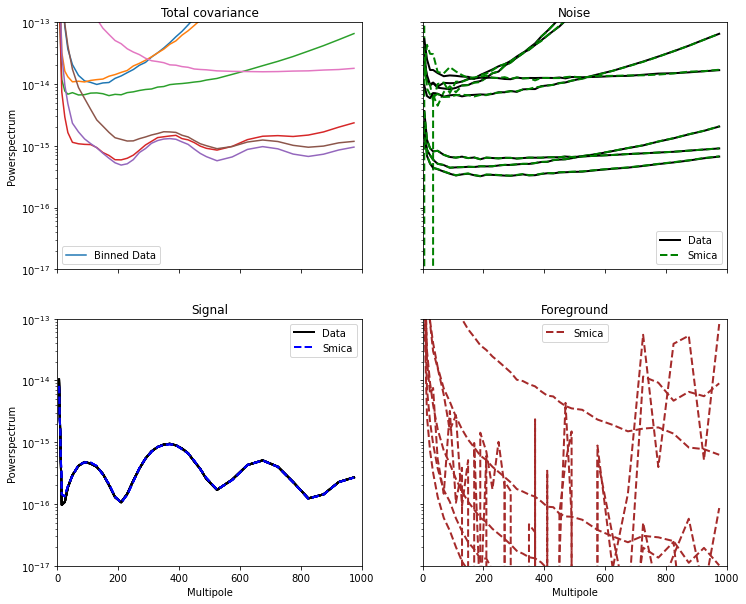

In [7]:
#%matplotlib widget
fig, axs = plt.subplots(2,2, figsize=(12,10), sharex=True,  sharey=True)
def logi(a, b):
    return a==b# and a>=3 and b>=3
ax=axs[0,0]
ax.set_title('Total covariance')
ax.set_yscale('log')
ax.set_ylabel('Powerspectrum')
ax.set_xlim((0,1000))
ax.set_ylim((1e-17,1e-13))
lab1 = 'Binned Data'
lab3 = 'Data'
lab2 = 'Smica'
for n in range(covltot_bnd.shape[1]):
    for m in range(covltot_bnd.shape[1]):
        if logi(n, m):# and n<3 and m<3:
#             ax.plot(covltot[1,n,m,:], color = 'black', ls='--', label=lab3, alpha=0.1)
            if n==m:
                ax.plot(np.mean(bins, axis=1), covltot_bnd[n,m,:], label=lab1)
            else:
                ax.plot(np.mean(bins, axis=1), covltot_bnd[n,m,:], label=lab1)
#             ax.plot(covltotEE[n,m,:], label=lab1, color = 'black')
            lab1 = None
            lab2 = None
            lab3 = None
ax.legend()

ax=axs[0,1]
ax.set_title('Noise')
ax.set_yscale('log')
lab1 = 'Data' 
lab2 = 'Smica' 
for n in range(covlN.shape[1]):
    for m in range(covltot_bnd.shape[1]):
         if logi(n, m):
            if n==m:
                ax.plot(np.mean(bins, axis=1), covlN_bnd[n,:], color= 'black', lw=2, label=lab1)
                ax.plot(np.mean(bins, axis=1), smica_params['cov4D'][TEB-1,n,m,:,2], color= 'green', lw=2, label=lab2, ls='--')
                lab1 = None
                lab2 = None
                ax.legend()         
            else:
                ax.text(lmaxbins-100, 1e0, 'Noise diagonal')

ax=axs[1,0]
ax.set_title('Signal')
ax.set_xlabel('Multipole')
ax.set_yscale('log')
ax.set_ylabel('Powerspectrum')
ax.set_ylim((1e-17, 1e-13))
lab1 = 'Data' 
lab2 = 'Smica' 
for n in range(covlS_bnd.shape[0]):
    for m in range(covlS_bnd.shape[1]):
        if logi(n, m):
            ax.plot(np.mean(bins, axis=1), covlS_bnd[n,m,:], color= 'black', lw=2, label=lab1)
            ax.plot(np.mean(bins, axis=1), smica_params['cov4D'][TEB-1,n,m,:,0], color= 'blue', lw=2, label=lab2, ls='--')
            lab1 = None
            lab2 = None
ax.legend()

ax=axs[1,1]
ax.set_title('Foreground')
ax.set_xlabel('Multipole')
ax.set_yscale('log')
lab1 = 'Data' 
lab2 = 'Smica' 
for n in range(smica_params['cov4D'].shape[1]):
    for m in range(smica_params['cov4D'].shape[2]):
        if logi(n, m):
            ax.plot(np.mean(bins, axis=1), smica_params['cov4D'][TEB-1,n,m,:,1], color= 'brown', lw=2, label=lab2, ls='--')
            lab1 = None
            lab2 = None
ax.legend()

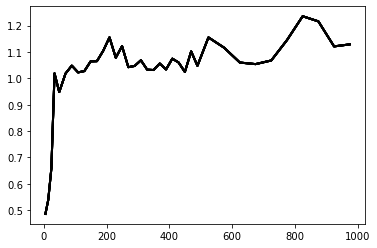

In [7]:
for n in range(covlS_bnd.shape[0]):
    for m in range(covlS_bnd.shape[1]):
        if logi(n, m):
            plt.plot(np.mean(bins, axis=1), covlS_bnd[n,m,:]/smica_params['cov4D'][TEB-1,n,m,:,0], color= 'black', lw=2, label=lab1)

Text(0.5, 1.0, 'Noise amplitude change in SMICA fit')

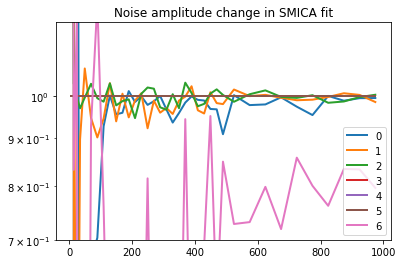

In [18]:
for n in range(covlN.shape[1]):
    for m in range(covltot_bnd.shape[1]):
         if logi(n, m):
            if n==m:
                plt.plot(np.mean(bins, axis=1), smica_params['cov4D'][TEB-1,n,m,:,2]/covlN_bnd[n,:], lw=2, label=n, alpha=1.0)
                lab1 = None
                lab2 = None
                plt.legend()
plt.yscale('log')
plt.ylim((0.7,1.2))
plt.title('Noise amplitude change in SMICA fit')

In [19]:
W_mv = io.load_data(fn.get_misc('w', simid=simid))
W_smica = io.load_data(fns.get_misc('w', simid=simid))
W_total = hpf.interp_smica_mv_weights(W_smica, W_mv, bins, 4001)
W_total[:,:,0:2] = 0.0
W_propag = np.loadtxt("/global/homes/s/sebibel/ext/smica_propagation/weights_EB_smica_R3.00.txt").reshape(2,7,4001)
beam5 = hp.gauss_beam(0.00145444, csu.lmax, pol = True)[:,1]
bcorr = np.array([
    hp.gauss_beam(val, csu.lmax, pol = True)[:,1]
    for val in [
        0.00930842,
        0.00785398,
        0.00378155,
        0.002807071,
        0.002106031,
        0.00145444,
        0.00140499,
        ]
    ])

loaded /global/cscratch1/sd/sebibel/compsep/planck/DX12/smicamask/w_JC.npy
loaded /global/cscratch1/sd/sebibel/compsep/planck/DX12/smicamask/smica_w_SMICA_highell_bins_JC.npy


In [ ]:
fig = plt.figure(figsize=(8,6))
plt.ylim((-0.2,1.1))
plt.title('{}\n{}, {} mask\nSolid from SMICA fit'.format(csu.freqdset, csu.binname, csu.mskset))
plt.xlabel('Multipole')
plt.ylabel('Weight')
#     plt.xscale('log')
lab1 = 'Propagation code'
for freq in range(0, 7):#W_smica.shape[1]):
    freqc = '-'.join([csu.FREQ[freq],csu.FREQ[freq]])

    #only for DX12 data
    plt.plot(W_propag[TEB-1,freq,:]*bcorr[freq]/beam5, color=colors[freq], label=lab1, lw=2, alpha=0.5, ls='-.')
     # lab1=None

    #This is the fitting result
    plt.plot(np.mean(bins, axis=1), W_smica[0,freq,:], color=colors[freq], label=csu.FREQ[freq], lw=3, ls='-')
    plt.plot(np.mean(bins, axis=1), W_smica[1,freq,:], color=colors[freq], lw=3, ls='--')
#         print(np.sum(((1+np.sum(W_s[0,0:3,:],axis=0))*W_s[0,3:7,:]),axis=0))pmask

    #This is the mv result
    mean, std, _ = hpf.std_dev_binned(np.nan_to_num(W_mv[1,freq,:]), binwidth=100, lmax=csu.lmax+1, log=True)
    plt.errorbar(((_[1:]+_[:-1])/2)[80:], mean[80:], yerr=std[80:], alpha=0.9, fmt='.', capsize=5, lw=2, color=colors[freq])

    mean, std, _ = hpf.std_dev_binned(np.nan_to_num(W_mv[2,freq,:]), binwidth=100, lmax=csu.lmax+1, log=True)
    plt.errorbar(((_[1:]+_[:-1])/2)[80:], mean[80:], yerr=std[80:], alpha=0.9, fmt='.', capsize=5, color=colors[freq])

plt.legend(loc='upper right')
plt.xlim((7.5,csu.lmax))
# plt.ylim((-0.05,0.2))
plt.xscale('log')

In [24]:
from component_separation.config_planck import Lens_Mask as LM
from component_separation.config_planck import Smica_Mask as SM

Tmask_LMfn = [os.path.join(LM.get_dir(), fn) 
    for fn in LM.get_fn("T")]
Pmask_LMfn = [os.path.join(LM.get_dir(), fn) 
    for fn in LM.get_fn("P")]

Tmask_SMfn = [os.path.join(SM.get_dir(), fn) 
    for fn in LM.get_fn("T")]
Pmask_SMfn = [os.path.join(SM.get_dir(), fn) 
    for fn in SM.get_fn("P")]

Tmask_LM = io.load_mask(Tmask_LMfn, stack=True)
Pmask_LM = io.load_mask(Pmask_LMfn, stack=True)

Tmask_SM = io.load_mask(Tmask_SMfn, stack=True)
Pmask_SM = io.load_mask(Pmask_SMfn, stack=True)

csuDXS = copy.copy(csu)
csuDXS.freqdset = 'DX12'
csuDXS.mskset = 'smica'
ioDXS= IO(csuDXS)
fnDXS= fn_gen(csuDXS)
fnsDXS = fns_gen(csuDXS)

csuNPL = copy.copy(csu)
csuNPL.freqdset = 'NPIPE'
csuNPL.mskset = 'lens'
ioNPL= IO(csuNPL)
fnNPL= fn_gen(csuNPL)
fnsNPL = fns_gen(csuNPL)

mapC_DXS = io.load_data(fnsDXS.get_map('T', 'combined'))
ClC_DXS = io.load_data(fnsDXS.get_spectrum('T', 'combined'))

mapC_NPL = io.load_data(fnNPL.get_map('T', 'combined'))
mapC_NPL = io.load_data(fnNPL.get_spectrum('T', 'combined'))

loaded /global/cscratch1/sd/sebibel/compsep/planck/DX12/smicamask/MapT_combined_SMICA_highell_bins_2048_4000_6000_JC.npy
loaded /global/cscratch1/sd/sebibel/compsep/planck/DX12/smicamask/ClT_combined_SMICA_highell_bins_2048_4000_6000_JC.npy


AssertionError: To be implemented

/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/projaxes.py:921: Mat

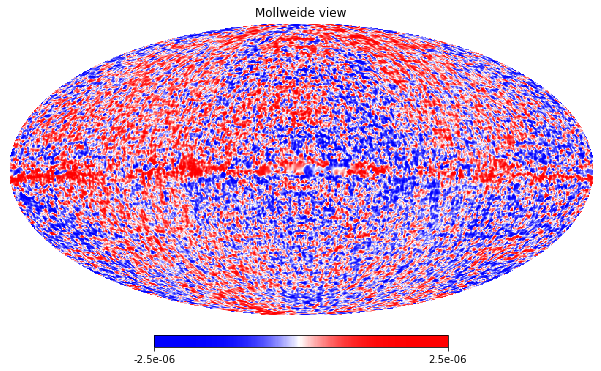

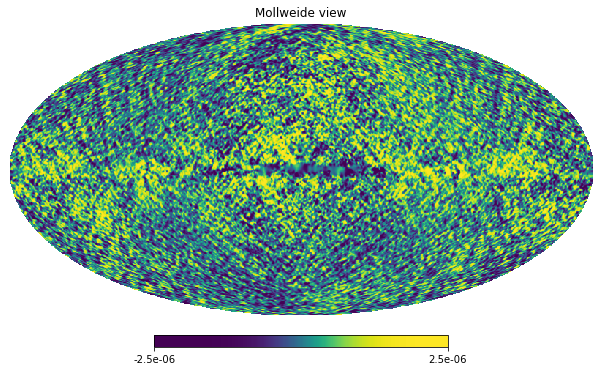

In [22]:
hp.mollview(Mapmin_smoothed[1], norm='hist', min=-2.5*1e-6, max=2.5*1e-6, cmap='bwr')
hp.mollview(Mapmin_smoothed[2], norm='hist', min=-2.5*1e-6, max=2.5*1e-6)